# Analysis

### Aufbau der Daten

Instanzname, Optimierungsstatus (Feasible oder Optimal), Fitness-Value, Lower Bound, Runtime (limitiert auf 3600 Sekunden), gefolgt von den Ergebnisvektoren, die aber für die Analyse eher zweitrangig sind

### Report Generation (Kennzahlen und Plots)

Kennzahlen zu der jeweiligen Benchmarkinstanz (für alle Instanzen), inklusive Anzahl Maschinen, Operationen, Flexibilität und Duration Variety, und eine statistische Analyse (normalerweise eher in Form von Plots), wie zBsp:

- Laufzeit im Vergleich zu der Problemgröße (Anzahl Operationen)
- Laufzeit im Vergleich zur Flexibilität
- Laufzeit im Vergleich zur Duration Variety
- Wie viel % der Instanzen konnten tatsächlich gelöst werden ( Status = Optimal)
- Das Ganze für alle Instanzen als Gesamtübersicht und dann zum Vergleich auch noch aufgeteilt auf die einzelnen Instanzgruppen (Quellen der Benchmarkinstanzen)

Die Flexibilität ist Durchschnittliche Anzahl von verfügbaren Maschinen für jede Operation / Gesamtanzahl Maschinen im System
Die Duration Variety ist Anzahl unterschiedlicher Duration Values in der Benchmarkinstanz / Gesamtanzahl von Duration Values der Instanz

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from benchmarkrewriter.benchmark_parser import BenchmarkParser
import statistics

In [2]:
file_content = pd.read_csv('cp_cplex_results.txt', names=['name','optimation_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2'], sep=';')
data = pd.DataFrame(file_content)

data

,name,optimation_status,fitness_value,lower_bound,runtime,result_vector1,result_vector2
0,Behnke1,Optimal,90.0,89.0,3.192,"[0, 13, 25, 36, 52, 23, 35, 47, 63, 73, 12, 26...","[2, 10, 9, 4, 16, 0, 12, 5, 12, 16, 1, 5, 15, ..."
1,Behnke10,Feasible,128.0,89.0,3600.020,"[54, 79, 90, 106, 118, 29, 56, 67, 77, 96, 11,...","[0, 4, 13, 5, 16, 1, 4, 4, 6, 16, 0, 14, 14, 6..."
2,Behnke11,Feasible,231.0,86.0,3600.040,"[147, 169, 179, 192, 207, 45, 62, 80, 100, 129...","[0, 11, 8, 12, 16, 3, 8, 15, 15, 16, 2, 4, 12,..."
3,Behnke12,Feasible,220.0,83.0,3600.050,"[155, 176, 189, 200, 210, 129, 140, 150, 174, ...","[3, 11, 8, 11, 19, 2, 9, 5, 10, 16, 1, 4, 13, ..."
4,Behnke13,Feasible,231.0,84.0,3600.040,"[122, 143, 155, 165, 182, 20, 34, 47, 59, 75, ...","[1, 15, 7, 6, 16, 0, 7, 14, 10, 18, 0, 8, 12, ..."
...,...,...,...,...,...,...,...
396,Fattahi5,Optimal,119.0,119.0,0.017,"[0, 55, 21, 55, 0, 76]","[1, 0, 0, 1, 0, 1]"
397,Fattahi6,Optimal,320.0,320.0,0.016,"[0, 47, 87, 17, 87, 237, 0, 60, 230]","[0, 0, 2, 0, 0, 2, 1, 1, 1]"
398,Fattahi7,Optimal,397.0,397.0,0.019,"[0, 117, 247, 0, 150, 205, 0, 62, 132]","[0, 1, 3, 2, 2, 2, 1, 3, 4]"
399,Fattahi8,Optimal,253.0,253.0,0.019,"[0, 25, 55, 0, 30, 85, 30, 86, 163]","[1, 1, 2, 0, 3, 3, 0, 1, 3]"


#### Benchmark Instances

Kennzahlen zu der jeweiligen Benchmarkinstanz (für alle Instanzen), inklusive Anzahl Maschinen, Operationen, Flexibilität und Duration Variety.
Die Flexibilität ist Durchschnittliche Anzahl von verfügbaren Maschinen für jede Operation / Gesamtanzahl Maschinen im System.
Die Duration Variety ist Anzahl unterschiedlicher Duration Values in der Benchmarkinstanz / Gesamtanzahl von Duration Values der Instanz.

In [3]:
def get_path(name: str):
    path = "../external_test_data/FJSSPinstances"

    if name.startswith("Behnke"):
        path += "/0_BehnkeGeiger/" + name 
    elif name.startswith("Brandimarte"):
        path += "/1_Brandimarte/" + name
    elif name.startswith("HurinkS"):
        path += "/2a_Hurink_sdata/" + name
    elif name.startswith("HurinkE"):
        path += "/2b_Hurink_edata/" + name 
    elif name.startswith("HurinkR"):
        path += "/2c_Hurink_rdata/" + name 
    elif name.startswith("HurinkV"):
        path += "/2d_Hurink_vdata/" + name 
    elif name.startswith("DPpaulli"):
        path += "/3_DPpaulli/" + name 
    elif name.startswith("ChambersBarnes"):
        path += "/4_ChambersBarnes/" + name
    elif name.startswith("Kacem"):
        path += "/5_Kacem/" + name
    elif name.startswith("Fattahi"):
        path += "/6_Fattahi/" + name

    return path + ".fjs"

In [4]:
benchmark_instances = []
all_benchmarks = pd.DataFrame()

for i, row in data.iterrows():
    read_path = get_path(row["name"])
    parser = BenchmarkParser()
    encoding = parser.parse_benchmark(read_path)

    extracted_data = {
        "name": [row["name"]],
        "n_jobs": [encoding.n_jobs()], 
        "n_machines": [encoding.n_machines()],
        "n_operations": [encoding.n_operations()],
        "durations": [encoding.durations()],
        "machines_for_all_operations": [encoding.get_machines_for_all_operations()]
    }
    df = pd.DataFrame(data=extracted_data)
    df.rename(index={0: i}, inplace=True)
    
    all_benchmarks = pd.concat([all_benchmarks, df])
    benchmark_instances.append(encoding)

all_benchmarks

,name,n_jobs,n_machines,n_operations,durations,machines_for_all_operations
0,Behnke1,10,20,50,"[[26, 24, 13, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 1, 2, 3], [8, 9, 10, 11], [8, 9, 10, 11, ..."
1,Behnke10,20,20,100,"[[25, 28, 28, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 1, 2, 3], [4, 5, 6, 7, 8, 9, 10, 11, 12, ..."
2,Behnke11,50,20,250,"[[22, 25, 19, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 1, 2, 3], [4, 5, 6, 7, 8, 9, 10, 11, 12, ..."
3,Behnke12,50,20,250,"[[18, 25, 27, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 1, 2, 3], [4, 5, 6, 7, 8, 9, 10, 11, 12, ..."
4,Behnke13,50,20,250,"[[24, 21, 23, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 1, 2, 3], [4, 5, 6, 7, 8, 9, 10, 11, 12, ..."
...,...,...,...,...,...,...
396,Fattahi5,3,2,6,"[[43, 36], [64, 71], [34, 53], [36, 21], [0, 0...","[[0, 1], [0, 1], [0, 1], [0, 1], [], []]"
397,Fattahi6,3,3,9,"[[17, 0, 0], [40, 130, 0], [0, 50, 60], [30, 0...","[[0], [0, 1], [1, 2], [0], [0, 1], [2], [], []..."
398,Fattahi7,3,5,9,"[[117, 125, 0, 0, 0], [0, 130, 0, 140, 0], [0,...","[[0, 1], [1, 3], [3, 4], [0, 2], [1, 2], [2, 4..."
399,Fattahi8,3,4,9,"[[17, 25, 0, 0], [0, 30, 0, 40], [0, 0, 160, 1...","[[0, 1], [1, 3], [2, 3], [0, 2], [1, 3], [2, 3..."


In [5]:
#Die Flexibilität ist Durchschnittliche Anzahl von verfügbaren Maschinen für jede Operation / Gesamtanzahl Maschinen im System.
def calculate_flexibility(machines_for_all_operations, n_machines): 
    counts = []

    for m in machines_for_all_operations:
        counts.append(len(m))
    
    return statistics.mean(counts) / n_machines

#Die Duration Variety ist Anzahl unterschiedlicher Duration Values in der Benchmarkinstanz / Gesamtanzahl von Duration Values der Instanz.
def calculate_duration_variety(durations):
    counts = []

    for d in durations:
        counts.append(len(d))

    return len(set(counts)) / len(counts)

In [6]:
benchmark_overview = pd.DataFrame()

for i, b in all_benchmarks.iterrows(): 
    extracted_data = {
        "name": [b["name"]],
        "n_jobs": [b["n_jobs"]],
        "n_machines": [b["n_machines"]],
        "n_operations": [b["n_operations"]],  
        "flexibility": [calculate_flexibility(b["machines_for_all_operations"], b["n_machines"])],
        "duration_variety": [calculate_duration_variety(b["durations"])]
    }

    df = pd.DataFrame(extracted_data)
    df.rename(index={0: i}, inplace=True)
    
    benchmark_overview = pd.concat([benchmark_overview, df])

benchmark_overview

,name,n_jobs,n_machines,n_operations,flexibility,duration_variety
0,Behnke1,10,20,50,0.272000,0.020000
1,Behnke10,20,20,100,0.290000,0.010000
2,Behnke11,50,20,250,0.314400,0.004000
3,Behnke12,50,20,250,0.322400,0.004000
4,Behnke13,50,20,250,0.316800,0.004000
...,...,...,...,...,...,...
396,Fattahi5,3,2,6,0.666667,0.166667
397,Fattahi6,3,3,9,0.333333,0.111111
398,Fattahi7,3,5,9,0.266667,0.111111
399,Fattahi8,3,4,9,0.333333,0.111111


#### Results

- Laufzeit im Vergleich zu der Problemgröße (Anzahl Operationen)
- Laufzeit im Vergleich zur Flexibilität
- Laufzeit im Vergleich zur Duration Variety
- Wie viel % der Instanzen konnten tatsächlich gelöst werden ( Status = Optimal)
- Das Ganze für alle Instanzen als Gesamtübersicht und dann zum Vergleich auch noch aufgeteilt auf die einzelnen Instanzgruppen (Quellen der Benchmarkinstanzen)

Die Flexibilität ist Durchschnittliche Anzahl von verfügbaren Maschinen für jede Operation / Gesamtanzahl Maschinen im System
Die Duration Variety ist Anzahl unterschiedlicher Duration Values in der Benchmarkinstanz / Gesamtanzahl von Duration Values der Instanz

Text(0, 0.5, 'Number of operations')

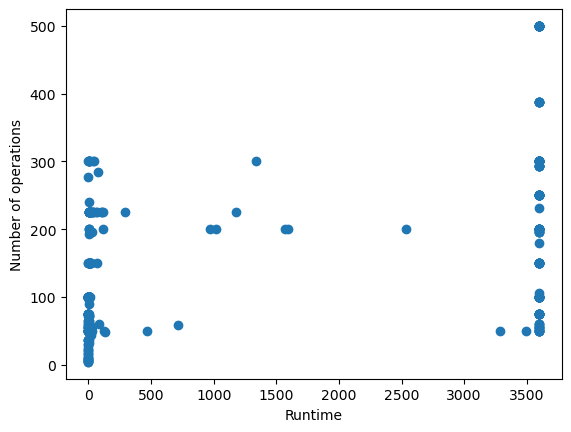

In [7]:
plt.plot(data["runtime"], benchmark_overview["n_operations"], 'o')
plt.xlabel("Runtime")
plt.ylabel("Number of operations")

Text(0, 0.5, 'Flexibility')

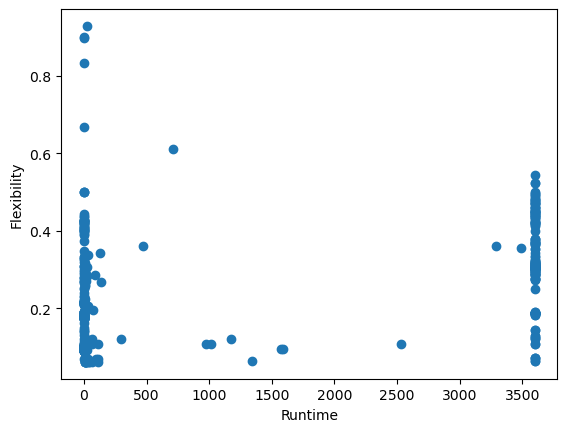

In [8]:
plt.plot(data["runtime"], benchmark_overview["flexibility"], 'o')
plt.xlabel("Runtime")
plt.ylabel("Flexibility")

Text(0, 0.5, 'Flexibility')

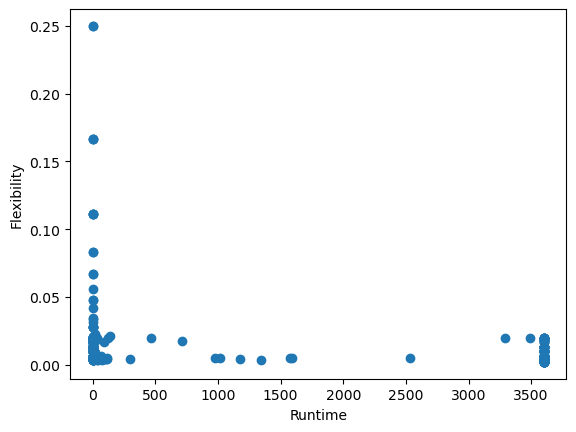

In [9]:
plt.plot(data["runtime"], benchmark_overview["duration_variety"], 'o')
plt.xlabel("Runtime")
plt.ylabel("Flexibility")

In [10]:
#- Wie viel % der Instanzen konnten tatsächlich gelöst werden ( Status = Optimal)

solved_instances = ([x for i, x in data.iterrows() if x["optimation_status"] == "Optimal"])

print(f"{len(solved_instances) / len(data) * 100}% of all instances could be solved")

63.34164588528678% of all instances could be solved
